In [49]:
# -*- coding: utf-8 -*-
#  Copyright 2024 United Kingdom Research and Innovation
#  Copyright 2024 The University of Manchester
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Hannah Robarts (UKRI-STFC)
#                   Laura Murgatroyd (UKRI-STFC)

# PaganinProcessor examples
This contains some examples and comparisons of using the `PaganinProcessor` phase retrieval methods in CIL 

This notebook requires CIL v24.1.0 or greater, check the version below

In [1]:
import cil
print(cil.__version__)

24.2.0


Load some dependencies from CIL

In [2]:
from cil.utilities import dataexample
from cil.processors import PaganinProcessor, TransmissionAbsorptionConverter, Padder, Normaliser
from cil.utilities.display import show2D
from cil.recon import FDK, FBP
from cil.io.utilities import HDF5_utilities
from cil.framework import AcquisitionGeometry, AcquisitionData

This notebook also requires TomoPy, numpy and matplotlib

In [3]:

from tomopy.prep.phase import retrieve_phase
import numpy as np
import matplotlib.pyplot as plt 
from scipy import constants

##### Parallel beam data

First we test the PaganinProcessor with parallel beam data. In the following cell
- Get a test parallel beam dataset 
- Perform a filtered back projection reconstruction using `FBP()`

In [4]:
data = dataexample.SIMULATED_PARALLEL_BEAM_DATA.get()
data.reorder(order='tigre')
data.geometry.config.units = 'um'
data_abs = -1*data.log()
ig = data.geometry.get_ImageGeometry()
fbp =  FBP(data_abs, ig)
recon = fbp.run(verbose=0)

Next we repeat the above steps with the PaganinProcessor

Choose the parameters to be used in the phase retrieval
- Delta and beta are the real and complex part of the material refractive index. These can be found for x-ray wavelengths at  https://henke.lbl.gov/optical_constants/getdb2.html. Here we just use some exagerated values to demonstrate the effect.
- The experiment peak energy in default units eV

In [5]:
delta = 1
beta = 0.002
energy = 40000

Run the phase retrieval using the `PaganinProcessor` which is implemented based on [Paganin 2002](https://onlinelibrary.wiley.com/doi/10.1046/j.1365-2818.2002.01010.x). The processor returns the material retrieved thickness, removing the effect of phase in the image

$$
T(x,y) = - \frac{1}{\mu}\ln\left (\mathcal{F}^{-1}\left 
        (\frac{\mathcal{F}\left ( M^2I_{norm}(x, y,z = \Delta) \right )}{1 + 
          \alpha\left ( k_x^2 + k_y^2 \right )}  \right )\right )
$$

where
- $T$, is the sample thickness,
- $\mu = \frac{4\pi\beta}{\lambda}$ is the material linear 
attenuation coefficient where $\beta$ is the complex part of the 
material refractive index and $\lambda=\frac{hc}{E}$ is the probe 
wavelength,
- $M$ is the magnification at the detector,
- $I_{norm}$ is the input image which is expected to be the 
normalised transmission data, 
- $\Delta$ is the propagation distance,
- $\alpha = \frac{\Delta\delta}{\mu}$ is a parameter determining 
the strength of the filter to be applied in Fourier space where 
$\delta` is the real part of the deviation of the material 
refractive index from 1 
- $k_x, k_y = \left ( \frac{2\pi p}{N_xW}, \frac{2\pi q}{N_yW} 
\right )$ where $p$ and $q$ are co-ordinates in a Fourier 
mesh in the range $-N_x/2$ to $N_x/2$ for an image with 
size $N_x, N_y$ and pixel size $W$.


In the following cell:
- Run the `PaganinProcessor` to retrieve $T(x,y)$ from the test dataset
- Reconstruct using FBP

In [6]:
processor = PaganinProcessor(delta=delta, beta=beta, energy=energy)
processor.set_input(data)
thickness = processor.get_output(override_geometry={'propagation_distance':10})
fbp =  FBP(thickness, ig)
recon_thickness = fbp.run(verbose=0)

# calculate mu to get recon_attenuation with the same scaling as the original image
attenuation = thickness*processor.mu
fbp =  FBP(attenuation, ig)
recon_attenuation = fbp.run(verbose=0)

100%|██████████| 300/300 [00:00<00:00, 1905.95it/s]


Next we test the phase retrieval using `PaganinProcessor(full_retrieval=False)`. In this implementation, the same filter is applied in Fourier space but the $-log()$ is not applied. 
$$
I_{filt} = \mathcal{F}^{-1}\left (\frac{\mathcal{F}\left ( 
        I(x, y,z = \Delta) \right )}
        {1 - \alpha\left ( k_x^2 + k_y^2 \right )}  \right )
$$
This gives flexibility to apply a Paganin-like filter but doesn't require data that has already been converted from transmission to absorption.


In [7]:
# Run PaganinProcessor as a filter using full_retrieval=False on the absorption data and reconstruct
processor = PaganinProcessor(delta=delta, beta=beta, energy=energy, full_retrieval=False)
processor.set_input(data_abs)
filtered_image = processor.get_output(override_geometry={'propagation_distance':10})
fbp =  FBP(filtered_image, ig)
recon_filter = fbp.run(verbose=0)

100%|██████████| 300/300 [00:00<00:00, 2404.74it/s]


For comparison run Tomopy phase retreival with raw data, then convert to absorption and reconstruct

In [8]:
tomopy_alpha = (1/(delta/beta))/(4*np.pi**2)
data_tomopy = data.copy()
data_tmp = retrieve_phase(data.array, pixel_size=processor.pixel_size, dist=processor.propagation_distance, energy=energy/1000, alpha=tomopy_alpha)
data_tomopy.fill(data_tmp)
data_tomopy = -1*data_tomopy.log()
ig = data_tomopy.geometry.get_ImageGeometry()
fbp =  FBP(data_tomopy, ig)
recon_tomopy = fbp.run(verbose=0)

Also run Tomopy phase retreival with absorption data and reconstruct

In [9]:
tomopy_alpha = (1/(delta/beta))/(4*np.pi**2)
data_tomopy_abs = data_abs.copy()
data_tmp = retrieve_phase(data_abs.array, pixel_size=processor.pixel_size, dist=processor.propagation_distance, energy=energy/1000, alpha=tomopy_alpha)
data_tomopy_abs.fill(data_tmp)
ig = data_tomopy_abs.geometry.get_ImageGeometry()
fbp =  FBP(data_tomopy_abs, ig)
recon_tomopy_abs = fbp.run(verbose=0)

Compare the reconstructions

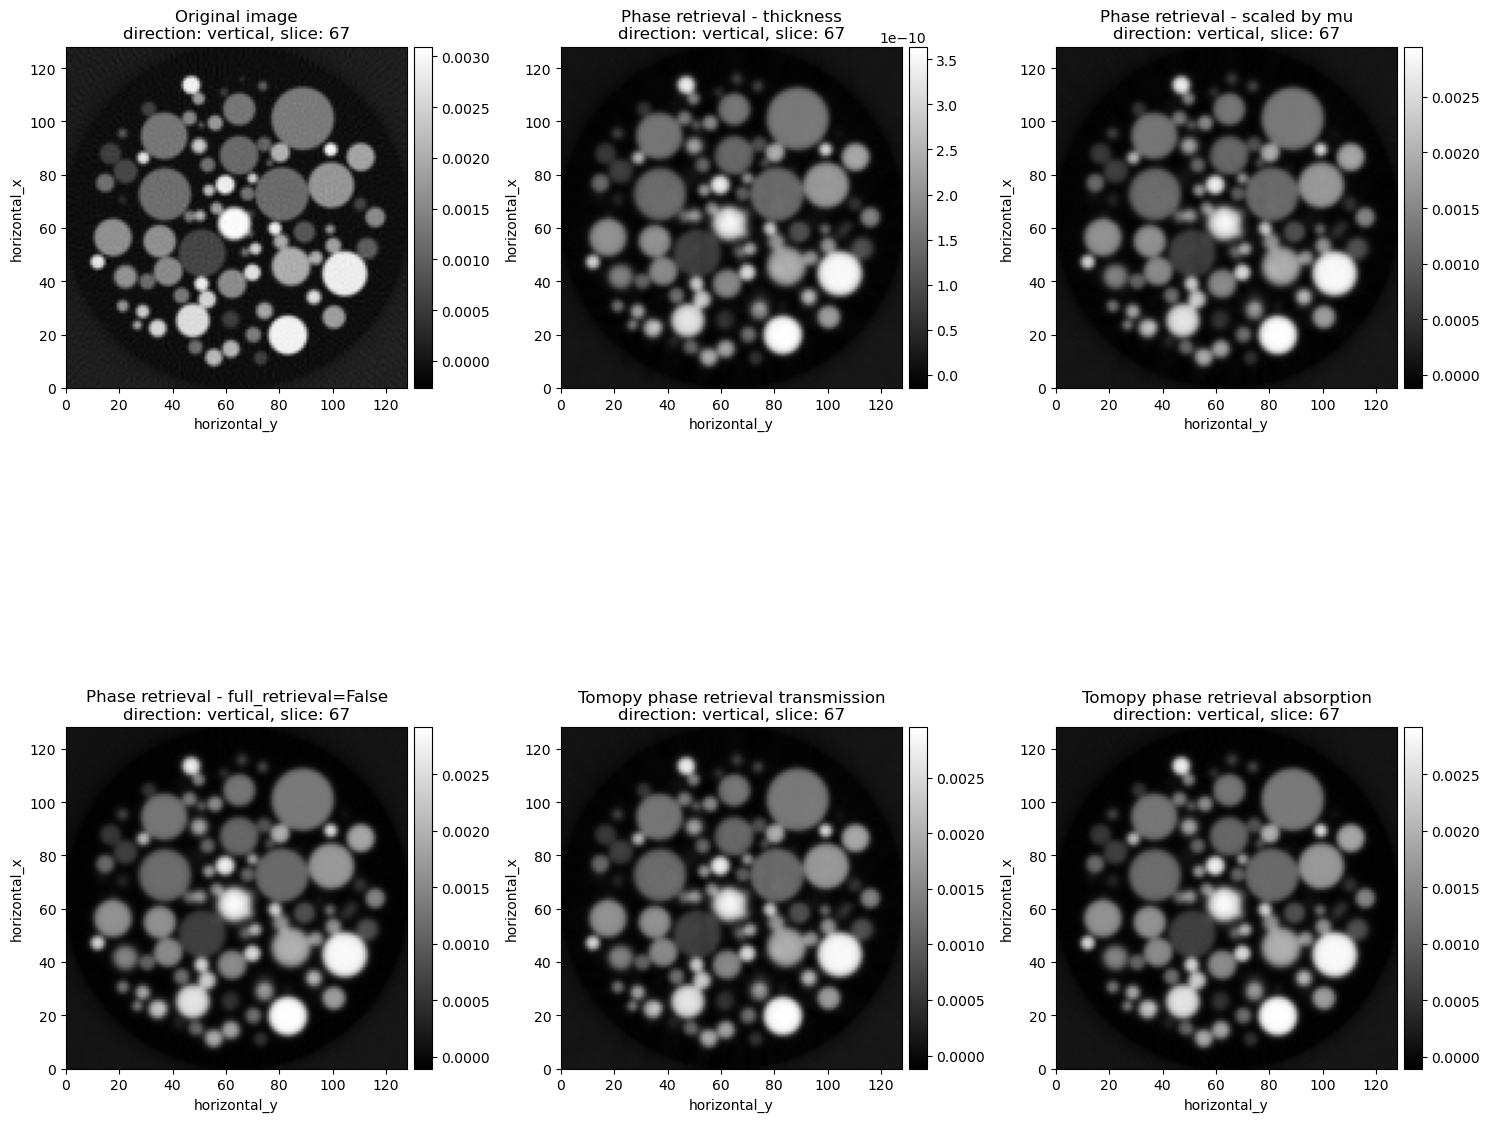

In [10]:
vertical_slice = 67
show2D([recon, recon_thickness, recon_attenuation, recon_filter, recon_tomopy, recon_tomopy_abs],
        title=['Original image', 'Phase retrieval - thickness', 'Phase retrieval - scaled by mu', 
               'Phase retrieval - full_retrieval=False', 'Tomopy phase retrieval transmission', 'Tomopy phase retrieval absorption'], 
        axis_labels = ('horizontal_y', 'horizontal_x'), num_cols=3, slice_list=('vertical',vertical_slice))


Zoom in on the reconstructions

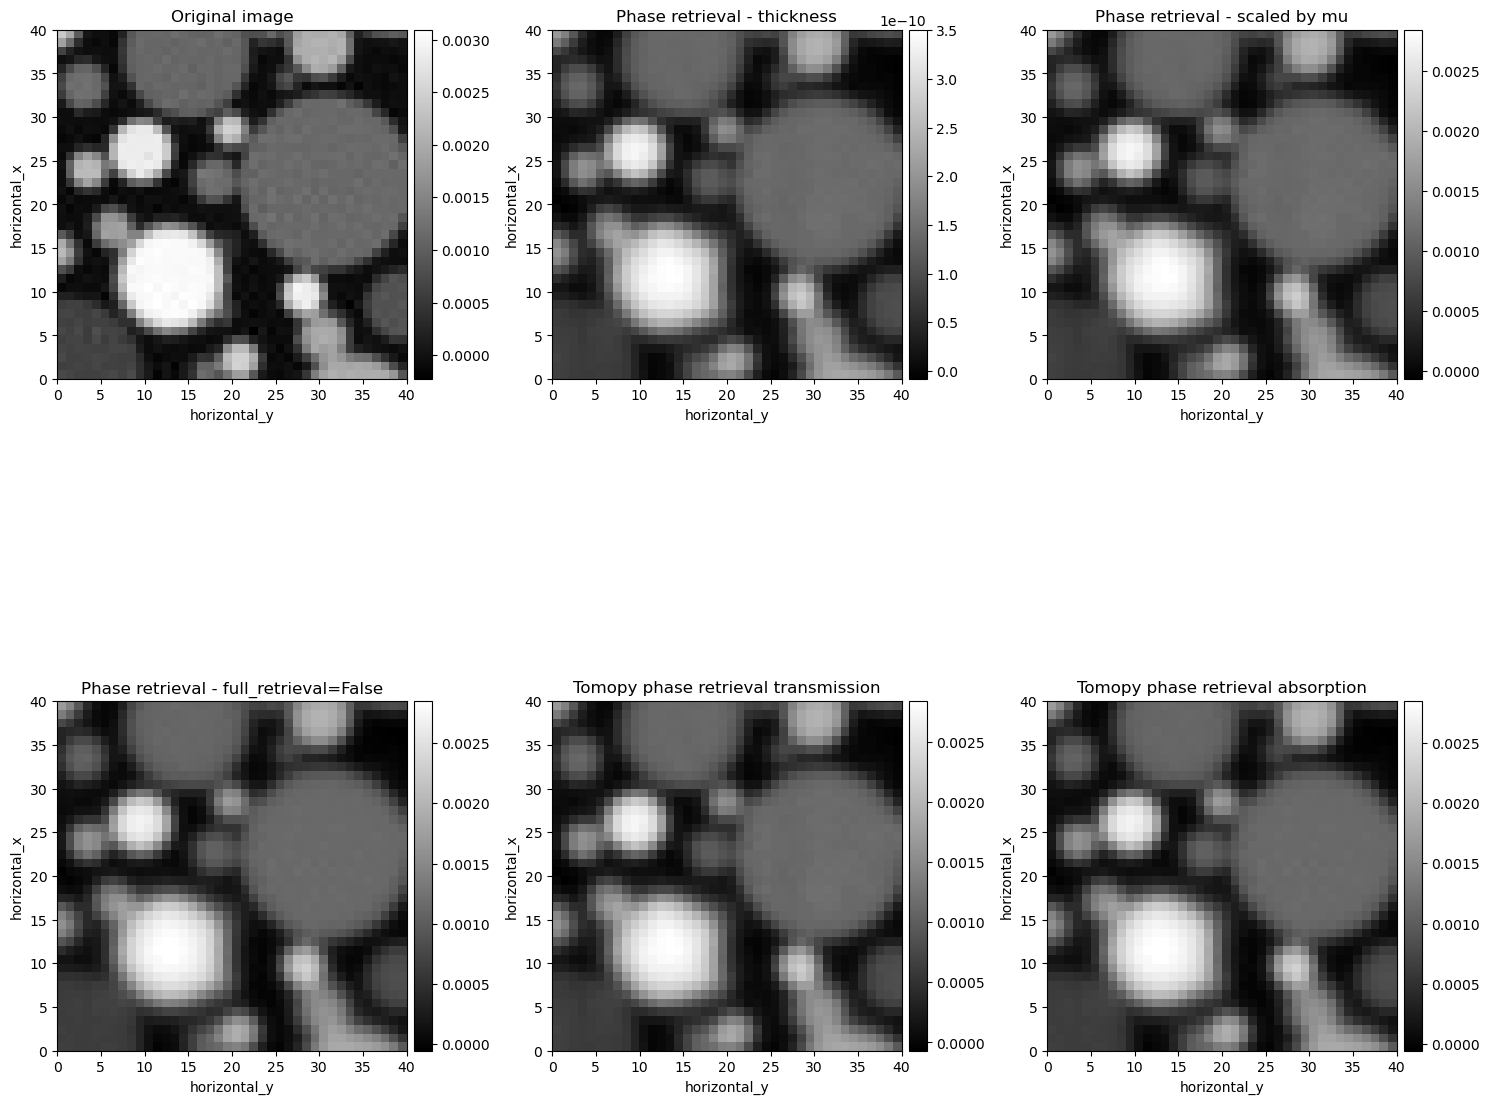

In [11]:
vertical_slice = 67
x_range = slice(50,90)
y_range = slice(50,90)

show2D([recon.array[vertical_slice,x_range,y_range], recon_thickness.array[vertical_slice,x_range,y_range], recon_attenuation.array[vertical_slice,x_range,y_range], recon_filter.array[vertical_slice,x_range,y_range], recon_tomopy.array[vertical_slice,x_range,y_range], recon_tomopy_abs.array[vertical_slice,x_range,y_range]],
title=['Original image', 'Phase retrieval - thickness', 'Phase retrieval - scaled by mu', 'Phase retrieval - full_retrieval=False', 'Tomopy phase retrieval transmission', 'Tomopy phase retrieval absorption'], 
axis_labels = ('horizontal_y', 'horizontal_x'), num_cols=3)

Compare a cross-section through the reconstruction

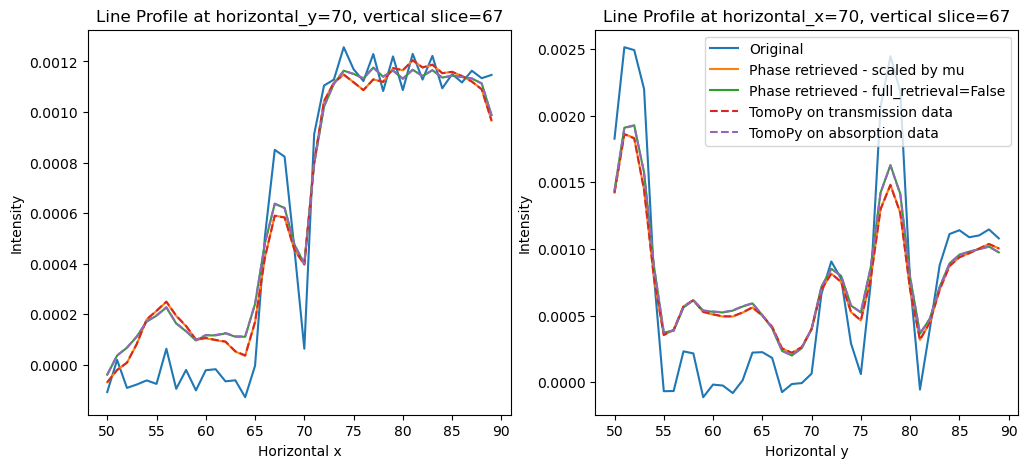

In [12]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
ax = axs[0]
vertical_slice = 67
y_slice = 70
x_range = range(50,90)
ax.plot(x_range, recon.array[vertical_slice,y_slice,x_range])
ax.plot(x_range, recon_attenuation.array[vertical_slice,y_slice,x_range])
ax.plot(x_range, recon_filter.array[vertical_slice,y_slice,x_range])
ax.plot(x_range, recon_tomopy.array[vertical_slice,y_slice,x_range],'--')
ax.plot(x_range, recon_tomopy_abs.array[vertical_slice,y_slice,x_range],'--')

ax.set_xlabel('Horizontal x')
ax.set_ylabel('Intensity')
ax.set_title('Line Profile at horizontal_y=' + str(y_slice) + ', vertical slice=' + str(vertical_slice))

ax = axs[1]
x_slice = 70
y_range = range(50,90)
ax.plot(y_range, recon.array[vertical_slice,y_range,x_slice])
ax.plot(y_range, recon_attenuation.array[vertical_slice,y_range,x_slice])
ax.plot(y_range, recon_filter.array[vertical_slice,y_range,x_slice])
ax.plot(y_range, recon_tomopy.array[vertical_slice,y_range,x_slice],'--')
ax.plot(y_range, recon_tomopy_abs.array[vertical_slice,y_range,x_slice],'--')

ax.set_xlabel('Horizontal y')
ax.set_ylabel('Intensity')
ax.set_title('Line Profile at horizontal_x=' + str(x_slice) + ', vertical slice=' + str(vertical_slice))
ax.legend(['Original', 'Phase retrieved - scaled by mu', 'Phase retrieved - full_retrieval=False', 'TomoPy on transmission data', 'TomoPy on absorption data'])


We see that all methods blur the result in comparison to the original reconstruction. The scaled phase retrieval in CIL matches the Tomopy method performed on transmission data and the filter in CIL matches the Tomopy method performed on absorption data


We can approximate the signal to noise of each reconstruction as the mean divided by the standard deviation

In [13]:
print("Original reconstruction SNR = " + str(recon.mean()/recon.array.std()))
print("Phase retrieved reconstruction SNR = " + str(recon_attenuation.mean()/recon_attenuation.array.std()))
print("Phase retrieved (full_retrieval=False) reconstruction SNR = " + str(recon_filter.mean()/recon_filter.array.std()))
print("TomoPy on transmission data reconstruction SNR = " + str(recon_tomopy.mean()/recon_tomopy.array.std()))
print("TomoPy on absorption data reconstruction SNR = " + str(recon_tomopy_abs.mean()/recon_tomopy_abs.array.std()))

Original reconstruction SNR = 0.49501557656752926
Phase retrieved reconstruction SNR = 0.5525573901222521
Phase retrieved (full_retrieval=False) reconstruction SNR = 0.5565756784352969
TomoPy on transmission data reconstruction SNR = 0.5528618565967559
TomoPy on absorption data reconstruction SNR = 0.5568976296272605


In all cases, the phase retrieval improves the SNR


##### Cone beam data

In [14]:
delta = 1
beta = 0.0001
energy = 40000

With cone beam data, the magnification $M$ has an effect on the phase retrieval\
$ T = -\frac{1}{\mu}\ln(F^{-1}\frac{F(M^2 I_{norm}(x,y,z=\Delta))}{1+\frac{\Delta\lambda\delta}{4\pi\beta}(k_x^2+k_y^2)/M})$\
The $M^2$ on top means sometimes we get a number larger than 1 inside the $\ln$

Get some cone beam data and perform reconstruction without phase retrieval

In [15]:
data = dataexample.SIMULATED_CONE_BEAM_DATA.get()
data.geometry.config.units = 'um'
print('Magnification = ' + str(data.geometry.magnification))
data.reorder(order='tigre')
data_abs = -1*data.log()
ig = data.geometry.get_ImageGeometry()
fdk =  FDK(data_abs, ig)
recon = fdk.run(verbose=0)

Magnification = 4.0


Run phase retrieval on raw data and reconstruct

In [16]:
processor = PaganinProcessor(delta=delta, beta=beta, energy=energy)
processor.set_input(data)
thickness = processor.get_output()
recon_thickness = fdk.run(verbose=0)
# calculate mu to get recon_attenuation with the same scaling as the original image
attenuation = thickness*processor.mu
fdk =  FDK(attenuation, ig)
recon_attenuation = fdk.run(verbose=0)

100%|██████████| 300/300 [00:00<00:00, 1995.13it/s]


Run PaganinProcessor as a filter using `get_output(full_retrieval=False)` on the absorption data and reconstruct

In [17]:
processor = PaganinProcessor(delta=delta, beta=beta, energy=energy, full_retrieval=False)
processor.set_input(data_abs)
filtered_image = processor.get_output()

fdk =  FDK(filtered_image, ig)
recon_filter = fdk.run(verbose=0)

100%|██████████| 300/300 [00:00<00:00, 2458.09it/s]


TomoPy can only be used with parallel beam data so we do not use it for comparison here

Compare the reconstructions

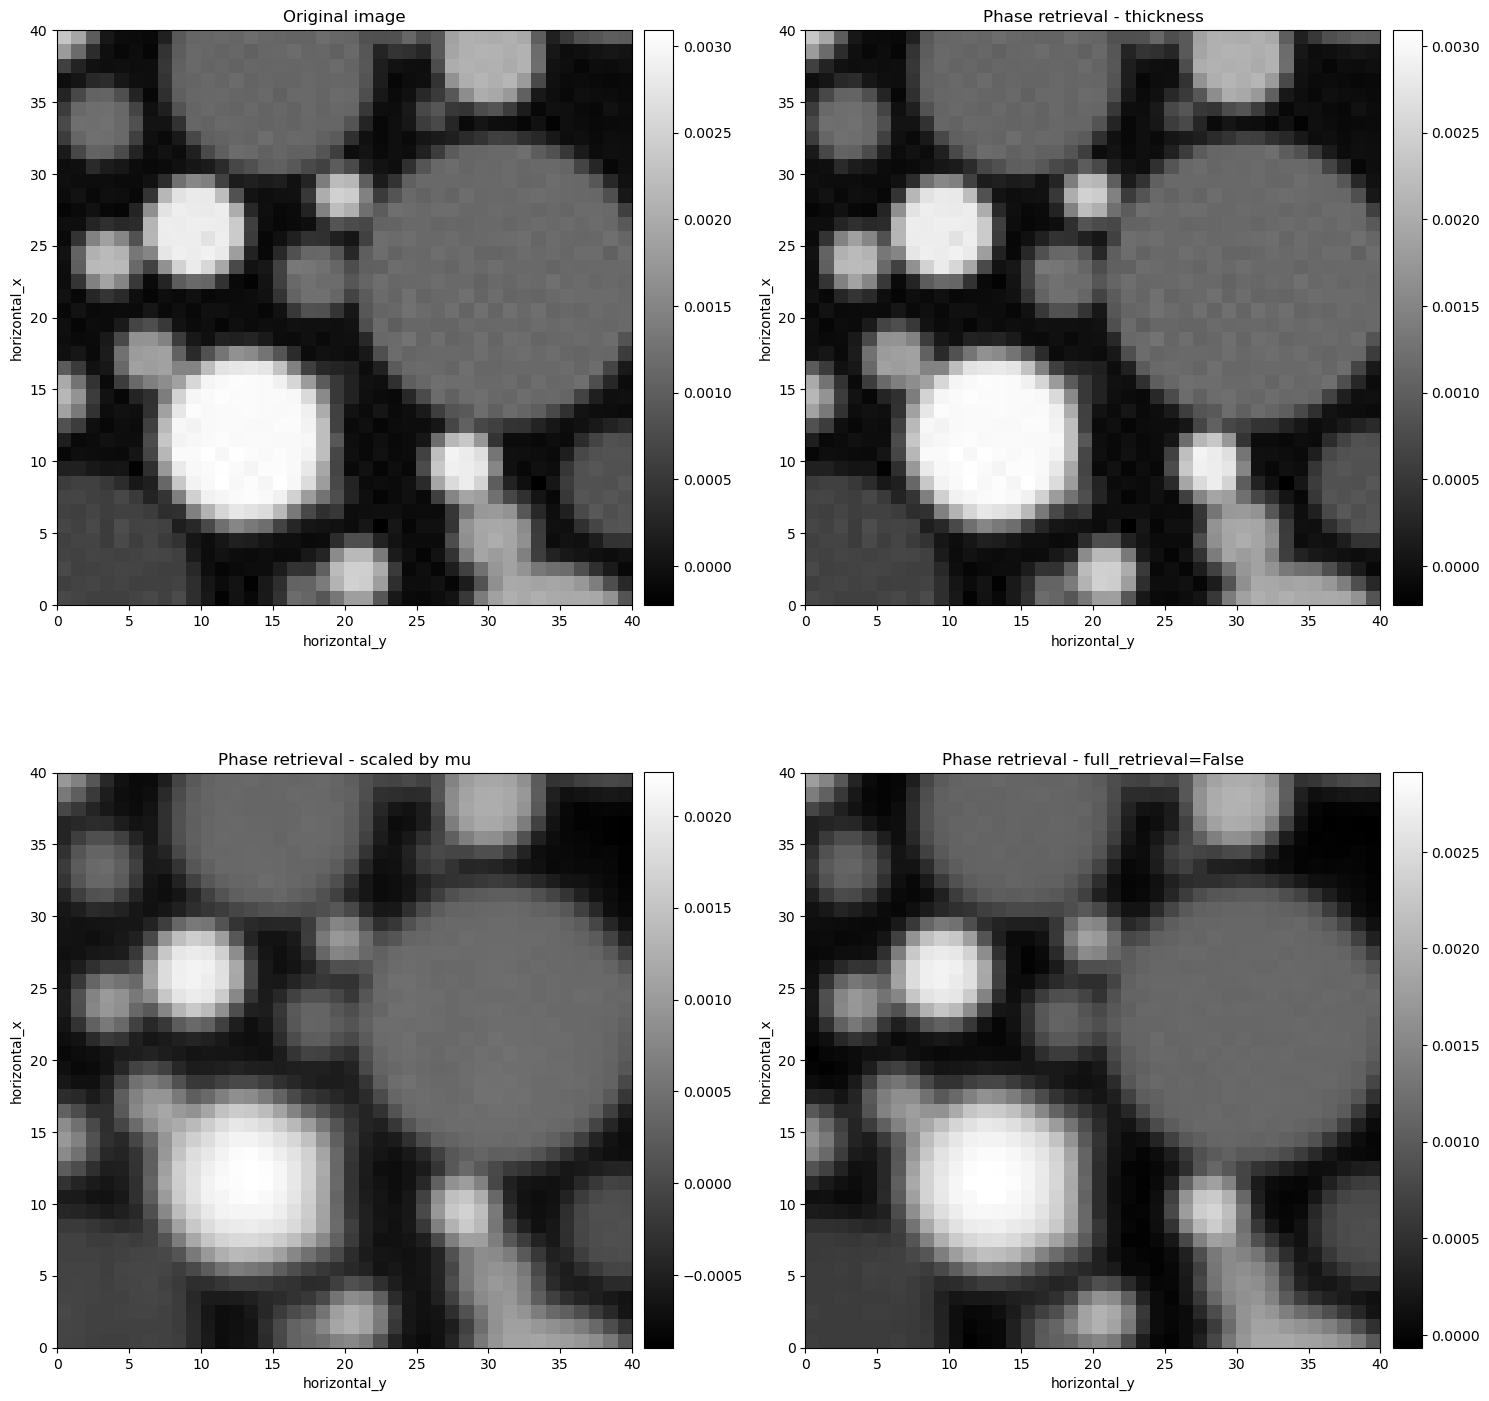

In [18]:
vertical_slice = 67
x_range = slice(50,90)
y_range = slice(50,90)
show2D([recon.array[vertical_slice,x_range,y_range], recon_thickness.array[vertical_slice,x_range,y_range], recon_attenuation.array[vertical_slice,x_range,y_range], recon_filter.array[vertical_slice,x_range,y_range]],
title=['Original image', 'Phase retrieval - thickness', 'Phase retrieval - scaled by mu', 'Phase retrieval - full_retrieval=False'],
axis_labels = ('horizontal_y', 'horizontal_x'))

Compare the cross-sections through the reconstructions

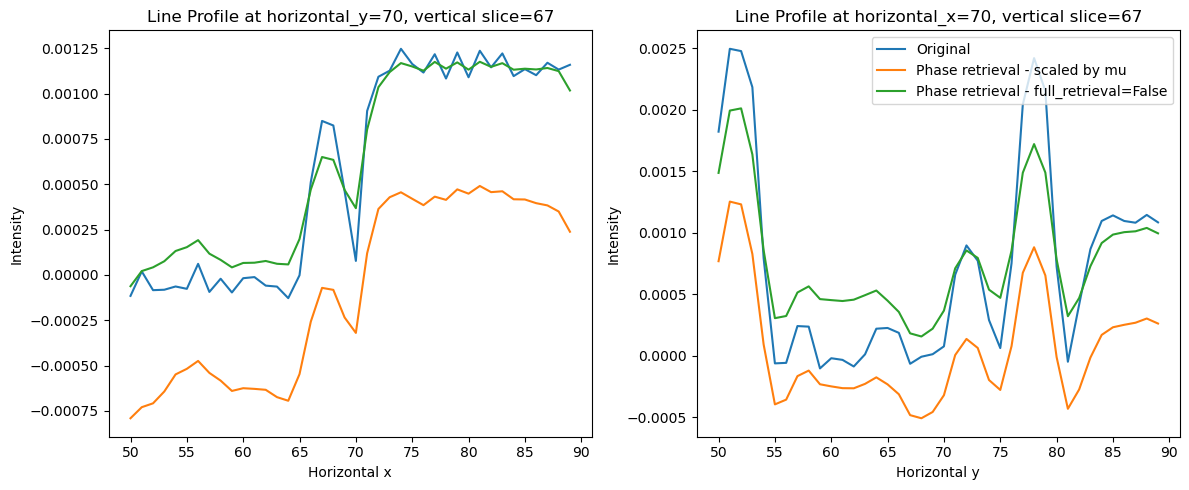

In [19]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
ax = axs[0]
vertical_slice = 67
y_slice = 70
x_range = range(50,90)
ax.plot(x_range, recon.array[vertical_slice, y_slice, x_range])
ax.plot(x_range, recon_attenuation.array[vertical_slice, y_slice, x_range])
ax.plot(x_range, recon_filter.array[vertical_slice, y_slice, x_range])

ax.set_xlabel('Horizontal x')
ax.set_ylabel('Intensity')
ax.set_title('Line Profile at horizontal_y=' + str(y_slice) + ', vertical slice=' + str(vertical_slice))

ax = axs[1]
x_slice = 70
y_range = range(50,90)
ax.plot(y_range, recon.array[vertical_slice,y_range,x_slice])
ax.plot(y_range, recon_attenuation.array[vertical_slice,y_range,x_slice])
ax.plot(y_range, recon_filter.array[vertical_slice,y_range,x_slice])

ax.set_xlabel('Horizontal y')
ax.set_ylabel('Intensity')
ax.set_title('Line Profile at horizontal_x=' + str(x_slice) + ', vertical slice=' + str(vertical_slice))
ax.legend(['Original', 'Phase retrieval - scaled by mu', 'Phase retrieval - full_retrieval=False'])

plt.tight_layout()


We can see that both methods blur the original image. The phase retrieval method becomes negative because of the values > 1 are passed into the negative log. This may be an indication that the full phase retrieval is not valid for this experimental setup, in which case using `full_retrieval = False` may be more useful as it just applies a Paganin-like filter to the data 

Compare the signal to noise ratio

In [20]:
print("Original reconstruction SNR = " + str(recon.mean()/recon.array.std()))
print("Phase retrieved reconstruction SNR = " + str(recon_attenuation.mean()/recon_attenuation.array.std()))
print("Phase retrieved (full_retrieval=False) reconstruction SNR = " + str(recon_filter.mean()/recon_filter.array.std()))

Original reconstruction SNR = 0.5024183277693794
Phase retrieved reconstruction SNR = -0.8009171345566614
Phase retrieved (full_retrieval=False) reconstruction SNR = 0.5502248549692288


The negative values in the phase retrival skew the result but with full_retrieval=False the SNR is improved

##### Generalised Paganin method

The generalised Paganin method is implemented in CIL following the description in https://iopscience.iop.org/article/10.1088/2040-8986/abbab9 \
When features in the image are close to the Nyquist frequency of the system, a more generalised form of the Pagnin filter can be used which preserves these high frequency features while still boosting SNR. This may have a similar effect to applying an unsharp mask after the normal Paganin phase retrieval. 

$$
T(x,y) =  -\frac{1}{\mu}\ln\left (\mathcal{F}^{-1}\left (\frac{
        \mathcal{F}\left ( M^2I_{norm}(x, y,z = \Delta) \right )}{1 - \frac{2
        \alpha}{W^2}\left ( \cos(Wk_x) + \cos(Wk_y) -2 \right )}  \right )
        \right )
$$

Choose delta and beta

In [21]:
delta = 1
beta = 0.001

Get the simulated parallel data and perform the reconstruction without phase retrieval

In [22]:
data = dataexample.SIMULATED_PARALLEL_BEAM_DATA.get()
data.geometry.config.units = 'um'
data.reorder(order='tigre')
data_abs = -1*data.log()
ig = data.geometry.get_ImageGeometry()
fbp =  FBP(data_abs, ig)
recon = fbp.run(verbose=0)

Run phase retrival using the original Paganin method and reconstruct

In [23]:
processor = PaganinProcessor(delta=delta, beta=beta, energy=energy)
processor.set_input(data)
thickness = processor.get_output(override_geometry={'propagation_distance':10})
fbp =  FBP(thickness, ig)
recon_thickness = fbp.run(verbose=0)

# calculate mu to get recon_attenuation with the same scaling as the original image
attenuation = thickness*processor.mu
fbp =  FBP(attenuation, ig)
recon_attenuation = fbp.run(verbose=0)

100%|██████████| 300/300 [00:00<00:00, 1983.25it/s]


Run phase retrieval on the data using the generalised Paganin method and reconstruct

In [24]:
processor = PaganinProcessor(delta=delta, beta=beta, energy=energy, filter_type='generalised_paganin_method')
processor.set_input(data)
thickness_GPM = processor.get_output(override_geometry={'propagation_distance':10})
fbp =  FBP(thickness_GPM, ig)
recon_thickness_GPM = fbp.run(verbose=0)

# calculate mu to get recon_attenuation with the same scaling as the original image
attenuation_GPM = thickness_GPM*processor.mu
fbp =  FBP(attenuation_GPM, ig)
recon_attenuation_GPM = fbp.run(verbose=0)

100%|██████████| 300/300 [00:00<00:00, 1980.12it/s]


Plot cross-sections through the results

Text(0.5, 1.0, 'Line Profile at horizontal_x=70, vertical slice=67')

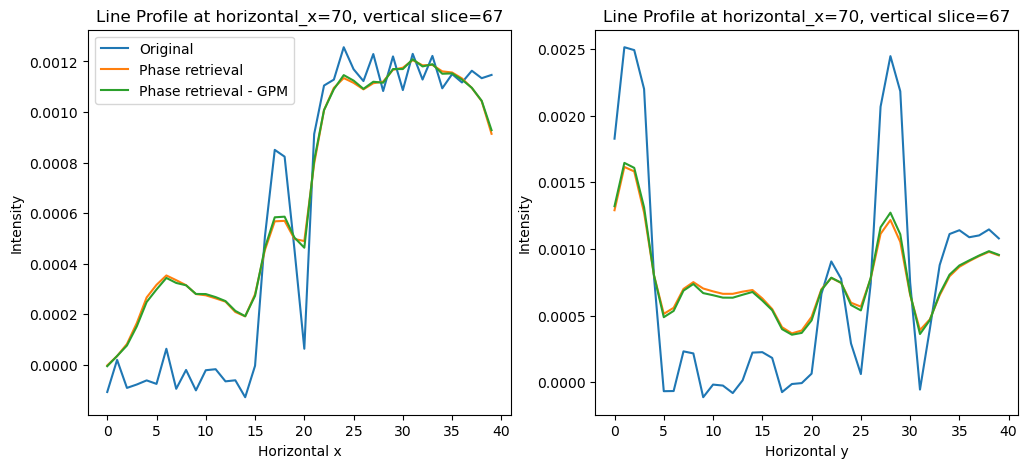

In [25]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
ax = axs[0]
vertical_slice = 67
y_slice = 70
x_range = range(50,90)
ax.plot(recon.array[vertical_slice, y_slice, x_range])
ax.plot(recon_attenuation.array[vertical_slice, y_slice, x_range])
ax.plot(recon_attenuation_GPM.array[vertical_slice, y_slice, x_range])

ax.set_xlabel('Horizontal x')
ax.set_ylabel('Intensity')
ax.set_title('Line Profile at horizontal_x=' + str(x_slice) + ', vertical slice=' + str(vertical_slice))
ax.legend(['Original', 'Phase retrieval', 'Phase retrieval - GPM'])

ax = axs[1]
x_slice = 70
y_range = range(50,90)
ax.plot(recon.array[vertical_slice,y_range,x_slice])
ax.plot(recon_attenuation.array[vertical_slice,y_range,x_slice])
ax.plot(recon_attenuation_GPM.array[vertical_slice,y_range,x_slice])

ax.set_xlabel('Horizontal y')
ax.set_ylabel('Intensity')
ax.set_title('Line Profile at horizontal_x=' + str(x_slice) + ', vertical slice=' + str(vertical_slice))


Check the SNR

In [26]:
print("Original reconstruction SNR = " + str(recon.mean()/recon.array.std()))
print("Phase retrieved reconstruction SNR = " + str(recon_attenuation.mean()/recon_attenuation.array.std()))
print("Phase retrieved with GPM reconstruction SNR = " + str(recon_attenuation_GPM.mean()/recon_attenuation_GPM.array.std()))

Original reconstruction SNR = 0.49501557656752926
Phase retrieved reconstruction SNR = 0.5871209727410079
Phase retrieved with GPM reconstruction SNR = 0.5853796621254054


The GPM has slightly improved resolution of the sample features while maintaining the SNR boost

#### TomoBank example

This example uses dataset tomo_00064 and tomo_00067 from TomoBank [1] https://tomobank.readthedocs.io/en/latest/source/data/docs.data.phasecontrast.html#multi-distance

The relevant datasets can be retrieved using:

`wget https://g-a0400.fd635.8443.data.globus.org/tomo_00064_to_00067/tomo_00064.h5`

and `wget https://g-a0400.fd635.8443.data.globus.org/tomo_00064_to_00067/tomo_00067.h5`

[1] De Carlo, Francesco, et al. “TomoBank: a tomographic data repository for computational x-ray science.” Measurement Science and Technology 29.3 (2018): 034004. http://www.doi.org/10.1088/1361-6501/aa9c19

Load the file, you may need to change the filename to the path where you downloaded it

In [27]:
filename = '/mnt/share/materials/SIRF/Fully3D/CIL/Phase/tomo_00065.h5' 
data = HDF5_utilities.read(filename=filename, dset_path='/exchange/data')
data_dark = HDF5_utilities.read(filename, dset_path='/exchange/data_dark')
data_flat = HDF5_utilities.read(filename, dset_path='/exchange/data_white')

Construct a CIL AcquisitionData object using the parameters in https://tomobank.readthedocs.io/en/latest/source/data/docs.data.phasecontrast.html#multi-distance

In [28]:
pixel_size = 0.0014 #mm
propagation_distance = 58 #mm
angles = HDF5_utilities.read(filename=filename, dset_path='/exchange/theta')
ag = AcquisitionGeometry.create_Parallel3D(detector_position=[0, propagation_distance, 0], units='mm').set_panel([np.shape(data)[2],np.shape(data)[1]], pixel_size=pixel_size).set_angles(angles)
data = AcquisitionData(data, deep_copy=False, geometry = ag)
data.reorder(order='tigre')

In [29]:
data = Normaliser(dark_field=data_dark.mean(axis=0), flat_field=data_flat.mean(axis=0))(data)

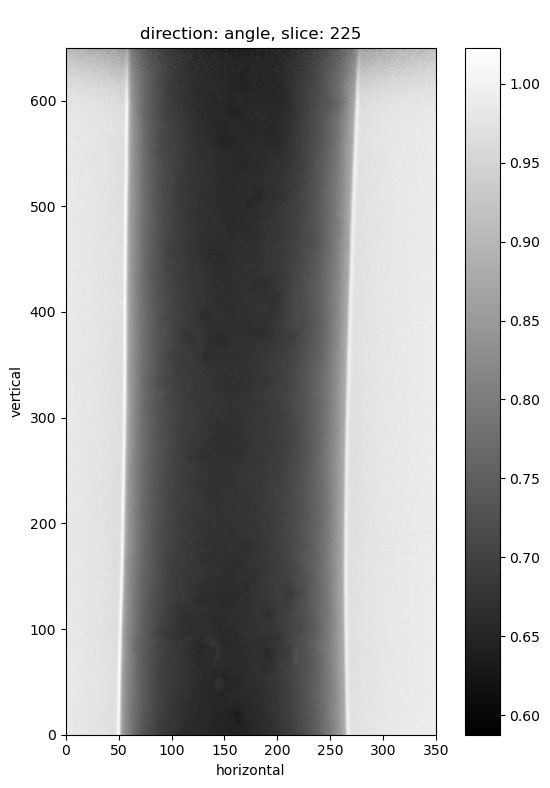

In [30]:
show2D(data)

Run phase retrieval on the raw data

Parameters from https://tomobank.readthedocs.io/en/latest/source/data/docs.data.phasecontrast.html#multi-distance

In [31]:
delta = 1
beta = 1e-2
energy = 55000

processor = PaganinProcessor(delta=delta, beta=beta, energy=energy)
processor.set_input(data)
thickness = processor.get_output()

# calculate mu to get recon_attenuation with the same scaling as the original image
data_phase = thickness*processor.mu

  3%|▎         | 14/450 [00:00<00:03, 133.68it/s]

100%|██████████| 450/450 [00:03<00:00, 134.70it/s]


Run phase retrieval using the generalised Paganin method on the raw data

In [32]:
processor = PaganinProcessor(delta=delta, beta=beta, energy=energy, 
                             filter_type='generalised_paganin_method')
processor.set_input(data)
thickness = processor.get_output()

# calculate mu to get recon_attenuation with the same scaling as the original image
data_phase_generalised = thickness*processor.mu

100%|██████████| 450/450 [00:03<00:00, 138.01it/s]


Get a slice of each data set

In [33]:
vertical_slice = 325
data_phase = data_phase.get_slice(vertical=vertical_slice)

In [34]:
vertical_slice = 325
data_phase_generalised = data_phase_generalised.get_slice(vertical=vertical_slice)

For comparison just run TransmissionAbsorptionConverter on the same slice of the original data

In [35]:
data_slice = data.get_slice(vertical=vertical_slice)

processor = TransmissionAbsorptionConverter()
processor.set_input(data_slice)
processor.get_output(out=data_slice)

Reconstruct all datasets

In [36]:
# Pad the data
ig = data_slice.geometry.get_ImageGeometry()
padsize = 500
data_slice = Padder.linear_ramp(pad_width={'horizontal': padsize}, end_values=0)(data_slice)
data_phase = Padder.linear_ramp(pad_width={'horizontal': padsize}, end_values=0)(data_phase)
data_phase_generalised = Padder.linear_ramp(pad_width={'horizontal': padsize}, end_values=0)(data_phase_generalised)

# Reconstruct
fbp =  FBP(data_slice, ig)
recon = fbp.run(verbose=0)

fbp =  FBP(data_phase, ig)
recon_phase = fbp.run(verbose=0)

fbp =  FBP(data_phase_generalised, ig)
recon_phase_g = fbp.run(verbose=0)

Compare the reconstructions

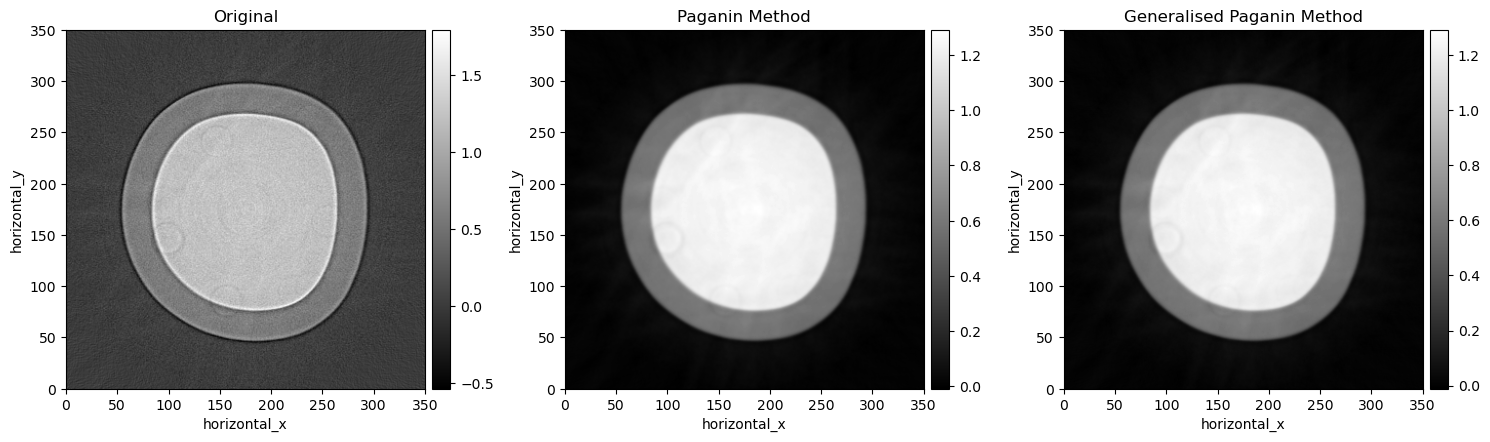

In [37]:
show2D([recon, recon_phase, recon_phase_g], ['Original','Paganin Method', 'Generalised Paganin Method'], num_cols=3, slice_list={'horizontal_y':175})

Plot a difference map between the Paganin Method and Generalised Paganin Method reconstructions

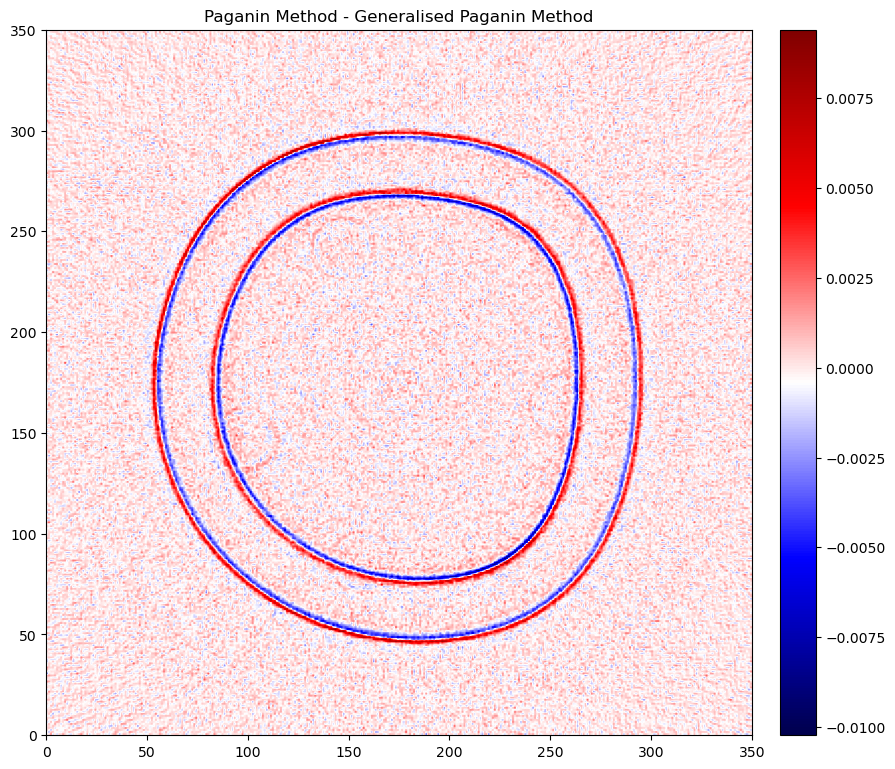

In [38]:
show2D(recon_phase.array-recon_phase_g.array, title='Paganin Method - Generalised Paganin Method', cmap='seismic', slice_list={'horizontal_y':175})

We see some of the high resolution details (e.g. the edges) are preserved in the GPM

Compare SNR

In [39]:
print("Original reconstruction SNR = " + str(recon.mean()/recon.array.std()))
print("Phase retrieved reconstruction SNR = " + str(recon_phase.mean()/recon_phase.array.std()))
print("Phase retrieved with GPM reconstruction SNR = " + str(recon_phase_g.mean()/recon_phase_g.array.std()))

Original reconstruction SNR = 0.773331974099942
Phase retrieved reconstruction SNR = 0.7970271834119154
Phase retrieved with GPM reconstruction SNR = 0.7969521013001704


Plot cross-sections through the reconstructions to check how well the phase retrieval removes the fringes

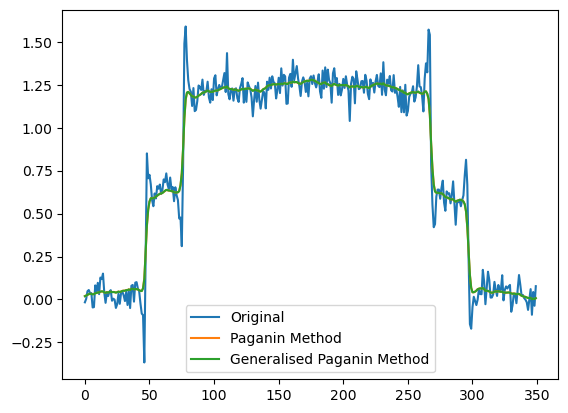

In [40]:
plt.plot(recon.array[:,175])
plt.plot(recon_phase.array[:,175])
plt.plot(recon_phase_g.array[:,175])
plt.legend(['Original', 'Paganin Method', 'Generalised Paganin Method'])

We can also compare the phase retrieval with the same sample which was imaged with a much shorted propagation distance (8mm)

In [41]:
filename = '/mnt/share/materials/SIRF/Fully3D/CIL/Phase/tomo_00064.h5' 
data_8mm = HDF5_utilities.read(filename=filename, dset_path='/exchange/data')
data_dark = HDF5_utilities.read(filename, dset_path='/exchange/data_dark')
data_flat = HDF5_utilities.read(filename, dset_path='/exchange/data_white')

In [42]:
pixel_size = 0.0014 #mm
propagation_distance = 8 #mm
angles = HDF5_utilities.read(filename=filename, dset_path='/exchange/theta')
ag = AcquisitionGeometry.create_Parallel3D(detector_position=[0, propagation_distance, 0], units='mm').set_panel([np.shape(data)[2],np.shape(data)[1]], pixel_size=pixel_size).set_angles(angles)
data_8mm = AcquisitionData(data_8mm, deep_copy=False, geometry = ag)
data_8mm.reorder(order='tigre')

In [43]:
data_8mm = Normaliser(dark_field=data_dark.mean(axis=0), flat_field=data_flat.mean(axis=0))(data_8mm)

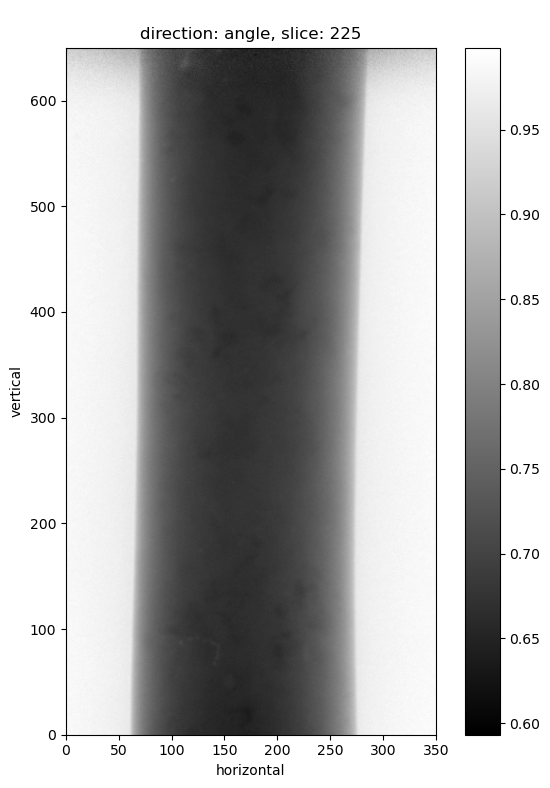

In [44]:
show2D(data_8mm)

Get a single slice and convert to absorption

In [45]:
data_slice_8mm = data_8mm.get_slice(vertical=vertical_slice)

processor = TransmissionAbsorptionConverter(min_intensity=0.001)
processor.set_input(data_slice_8mm)
processor.get_output(out=data_slice_8mm)


Pad the data and reconstruct it

In [46]:
# Pad the data
ig = data_slice_8mm.geometry.get_ImageGeometry()
padsize = 500
data_slice_8mm = Padder.linear_ramp(pad_width={'horizontal': padsize}, end_values=0)(data_slice_8mm)
# Reconstruct
fbp =  FBP(data_slice_8mm, ig)
recon_8mm = fbp.run(verbose=0)

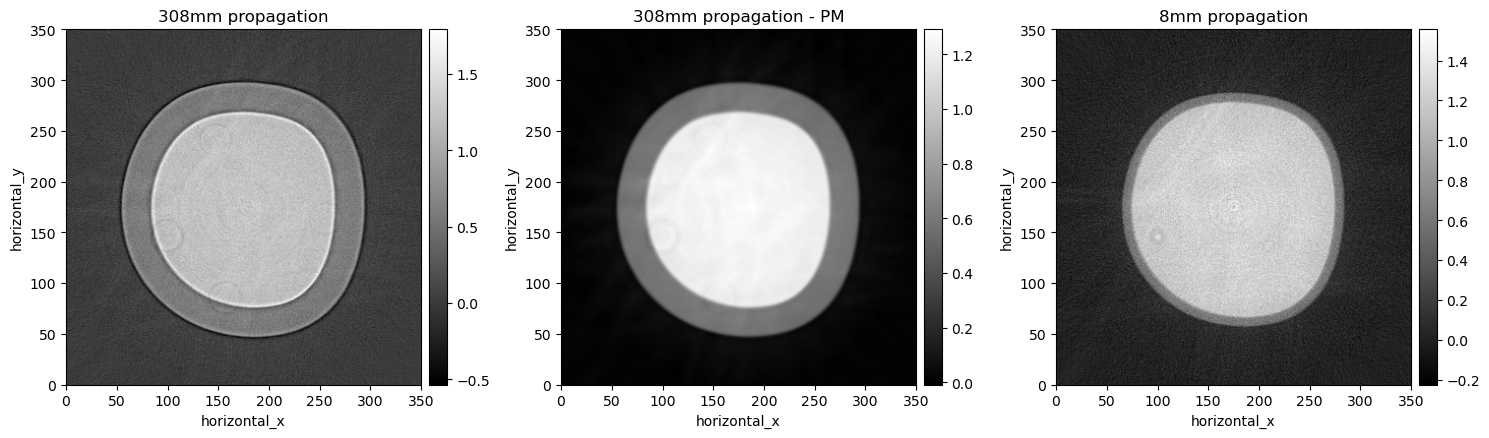

In [47]:
show2D([recon, recon_phase, recon_8mm], ['308mm propagation', '308mm propagation - PM', '8mm propagation'], num_cols=3, slice_list={'horizontal_y':175})

The phase retrieval acts as an effective filter but it doesn't return the original shape of the sample which was measured with 8mm propagation distance.

We can check if we are in the Fresnel limit by calculating the Fresnel Number
$$
N_F = \frac{W^2}{\lambda\Delta} >> 1
$$

In [59]:
wavelength = (constants.h*constants.speed_of_light)/(energy*constants.electron_volt)
NF = (data.geometry.pixel_size_h*1e-3)**2/(wavelength*308* 1e-3)
print(r"For propagation = 308mm, NF = " + str(NF))
NF = (data.geometry.pixel_size_h*1e-3)**2/(wavelength*8* 1e-3)
print(r"For propagation = 8mm, NF = " + str(NF))


For propagation = 308mm, NF = 0.28229403780722234
For propagation = 8mm, NF = 10.86832045557806


A Fresnel number less than 1 suggests different phase retrieval methods might be required to fully account for the phase effect in the data.